In [1]:
import gc
import os
import sys
import warnings
from glob import glob
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from torch.cuda import amp
from tqdm import tqdm

In [2]:
sys.path.append('../')
from script.metrics import *
from script.dataset import *
from script.helper import *
from script.scheduler import *
from script.model import *
from script.loss import *

# Config

In [17]:
class CFG:
    debug = False
    # ============== comp exp name =============
    comp_name = 'contrail'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'google-research-identify-contrails-reduce-global-warming'

    dataset_path = "/kaggle/working/dataset_train/pseud_ashcolor_4band/"
    new_label_path = f"{dataset_path}/labels/iter_0/"
    model_path = "/kaggle/working/notebook/experiment/v2/model22/model22/model22.pth"
    
    valid_batch_size = 32
    num_workers = 4
    
    valid_aug_list = [
        ToTensorV2(transpose_mask=True),
    ]



warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True
# set_seed(CFG.seed)
# os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)
pd.set_option('display.max_rows', 500)
pd.options.display.max_colwidth = 300

# Pseudo Labelling

In [22]:
train_df = pd.read_csv(f"{CFG.dataset_path}/train_df.csv")
label_df = train_df[train_df["label_path"].isnull()]
if CFG.debug:
    label_df=label_df[:2000]

label_df

,record_id,image_path,time,label_path
0,1000216489776414077,/kaggle/working/dataset_train/pseud_ashcolor_4band/images/1000216489776414077_0.npy,0,NaN
1,1000216489776414077,/kaggle/working/dataset_train/pseud_ashcolor_4band/images/1000216489776414077_1.npy,1,NaN
2,1000216489776414077,/kaggle/working/dataset_train/pseud_ashcolor_4band/images/1000216489776414077_2.npy,2,NaN
3,1000216489776414077,/kaggle/working/dataset_train/pseud_ashcolor_4band/images/1000216489776414077_3.npy,3,NaN
5,1000216489776414077,/kaggle/working/dataset_train/pseud_ashcolor_4band/images/1000216489776414077_5.npy,5,NaN
...,...,...,...,...
164226,999815704182867427,/kaggle/working/dataset_train/pseud_ashcolor_4band/images/999815704182867427_2.npy,2,NaN
164227,999815704182867427,/kaggle/working/dataset_train/pseud_ashcolor_4band/images/999815704182867427_3.npy,3,NaN
164229,999815704182867427,/kaggle/working/dataset_train/pseud_ashcolor_4band/images/999815704182867427_5.npy,5,NaN
164230,999815704182867427,/kaggle/working/dataset_train/pseud_ashcolor_4band/images/999815704182867427_6.npy,6,NaN


In [23]:
dataset_label = ContrailsDataset(label_df, CFG.valid_aug_list, "pseudo_labeling")
dataloader_label = DataLoader(dataset_label, batch_size=CFG.valid_batch_size, num_workers = CFG.num_workers)

In [24]:
model, dice_score, thresh=load_model(CFG.model_path)
model.eval()
print(f"{dice_score = :.4f}")
print(f"{thresh = }")

model_arch:  Unet
backbone:  timm-resnest200e
dice_score = 0.6675
thresh = 0.07


In [27]:
def pseudo_inference(dataloader_label, model, thresh, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    for i, (images, record_ids, times) in tqdm(enumerate(dataloader_label), total=len(dataloader_label)):
        images = images.cuda()
        with torch.no_grad():
            preds = model(images)
        preds = torch.sigmoid(preds).cpu().detach().numpy()
        preds_thresh = np.where(preds > thresh, 1, 0)

        for num in range(images.shape[0]):
            pred = preds_thresh[num, :, :, :].transpose(1, 2, 0)
            record_id = int(record_ids[num])
            time = int(times[num])
            save_path = f"{save_dir}/{record_id}_{time}.npy"
            np.save(save_path, pred)
            
pseudo_inference(dataloader_label, model, thresh, CFG.new_label_path)

100%|██████████| 4491/4491 [1:38:14<00:00,  1.31s/it]


In [28]:
!curl -X POST -H 'Authorization: Bearer '$LINE -F 'message=セルの実行が終わりました！' https://notify-api.line.me/api/notify

{"status":200,"message":"ok"}

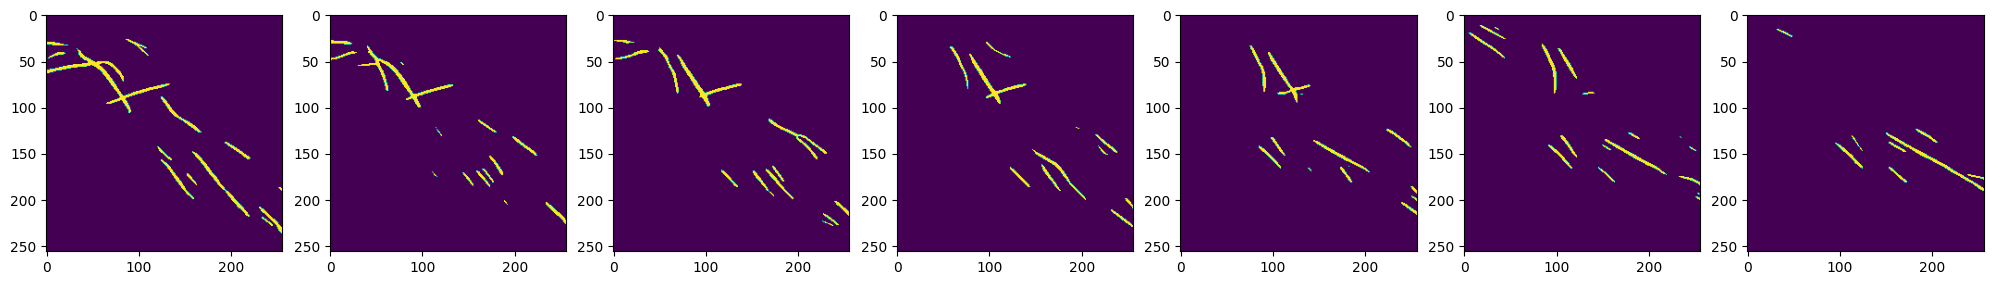

In [8]:
no = 16
id = os.listdir(CFG.new_label_path)[no*7].split("_")[0]
fig, ax = plt.subplots(1, 7, figsize=(25, 10))
for i, time in enumerate([0, 1, 2, 3, 5, 6, 7]):
    npy = np.load(f"{CFG.new_label_path}/{id}_{time}.npy")
    ax[i].imshow(npy)